# estimate $Q_\phi(X)$ for different combination of binary activities

$Q_\phi(X)$ will be used to assess support. 

In [1]:
import os
import numpy as np
from tqdm.notebook import tqdm, trange

In [2]:
from noah2 import data as D
from noah2 import util as U

In [3]:
import copy
import torch
from nflows import transforms, distributions, flows
from torch import optim
from torch.nn.utils.clip_grad import clip_grad_norm_

In [4]:
import corner as DFM
# --- plotting ---
import matplotlib as mpl
import matplotlib.pyplot as plt
mpl.rcParams['text.usetex'] = True
mpl.rcParams['font.family'] = 'serif'
mpl.rcParams['axes.linewidth'] = 1.5
mpl.rcParams['axes.xmargin'] = 1
mpl.rcParams['xtick.labelsize'] = 'x-large'
mpl.rcParams['xtick.major.size'] = 5
mpl.rcParams['xtick.major.width'] = 1.5
mpl.rcParams['ytick.labelsize'] = 'x-large'
mpl.rcParams['ytick.major.size'] = 5
mpl.rcParams['ytick.major.width'] = 1.5
mpl.rcParams['legend.frameon'] = False
%matplotlib inline

In [5]:
cuda = torch.cuda.is_available()
device = ("cuda:0" if cuda else "cpu")

## load training and testing data

In [6]:
# read full data set
DNoah = D.Noah2()
fema = DNoah._read_data_full(participants=False)

# select outcome and covariates
columns = DNoah._columns()[1:8]
column_labels = np.array(DNoah._column_labels()[1:8])

data = np.array([np.array(fema[col]) for col in columns]).T

# reduce dynamic scale
_data = data.copy()
_data[:,2] = np.log10(_data[:,2])
_data[:,3] = np.log10(_data[:,3])

In [9]:
# only keep non-participants 
activities =  [
            's_c310', 's_c320', 's_c330', 's_c340', 's_c350', 's_c360', 's_c370',
            's_c410', 's_c420', 's_c430', 's_c440', 's_c450',
            's_c510', 's_c520', 's_c530', 's_c540',
            's_c610', 's_c620', 's_c630']

scores = np.array([np.array(fema[col]) for col in activities]).T
non_participant = np.all(scores == 0, axis=1)
print('%i non-participant communities' % np.sum(non_participant))
print('%i non-participant zipcodes' % len(np.unique(fema['zipcode'][non_participant])))

391212 non-participant communities
3409 non-participant zipcodes


In [10]:
fema = fema[non_participant]
data = data[non_participant]
_data = _data[non_participant]

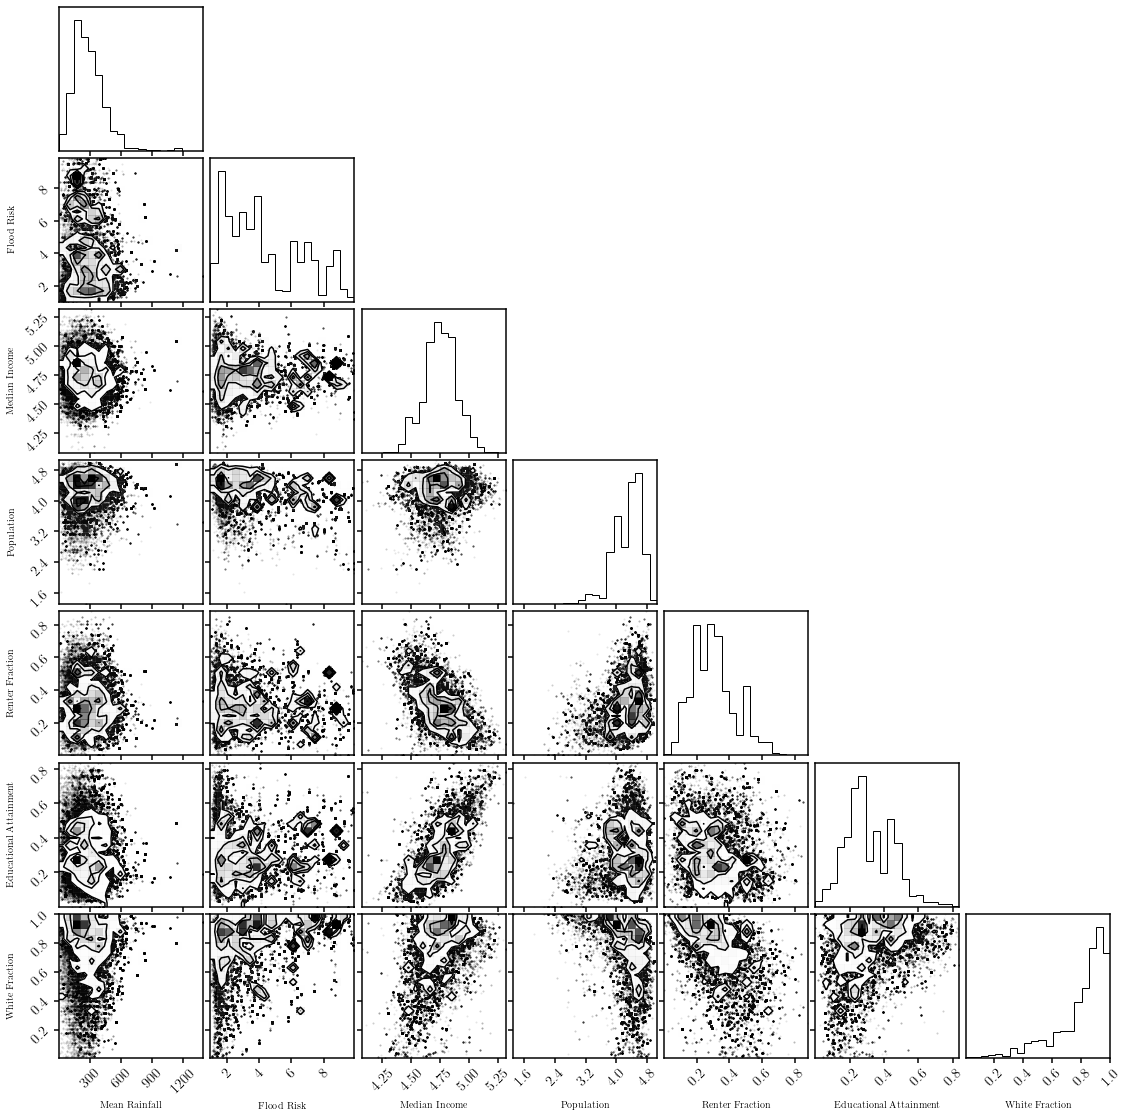

In [11]:
fig = DFM.corner(_data, labels=column_labels)

## downsample same zipcodes
There are many communities from the same zipcode. Lets reduce that.

In [12]:
zuniq, iuniq, nuniq = np.unique(fema['zipcode'], return_index=True, return_counts=True)

n_repeat = 1
remove = np.zeros(data.shape[0]).astype(bool)

for z in zuniq: 
    is_zip = (np.array(fema['zipcode']) == z)

    if np.sum(is_zip) > n_repeat:
        _remove = np.random.choice(np.arange(np.sum(is_zip)), np.sum(is_zip) - n_repeat, replace=False)
        remove[np.arange(_data.shape[0])[is_zip][_remove]] = True

In [13]:
np.sum(remove)

387803

In [14]:
_data = _data[~remove]

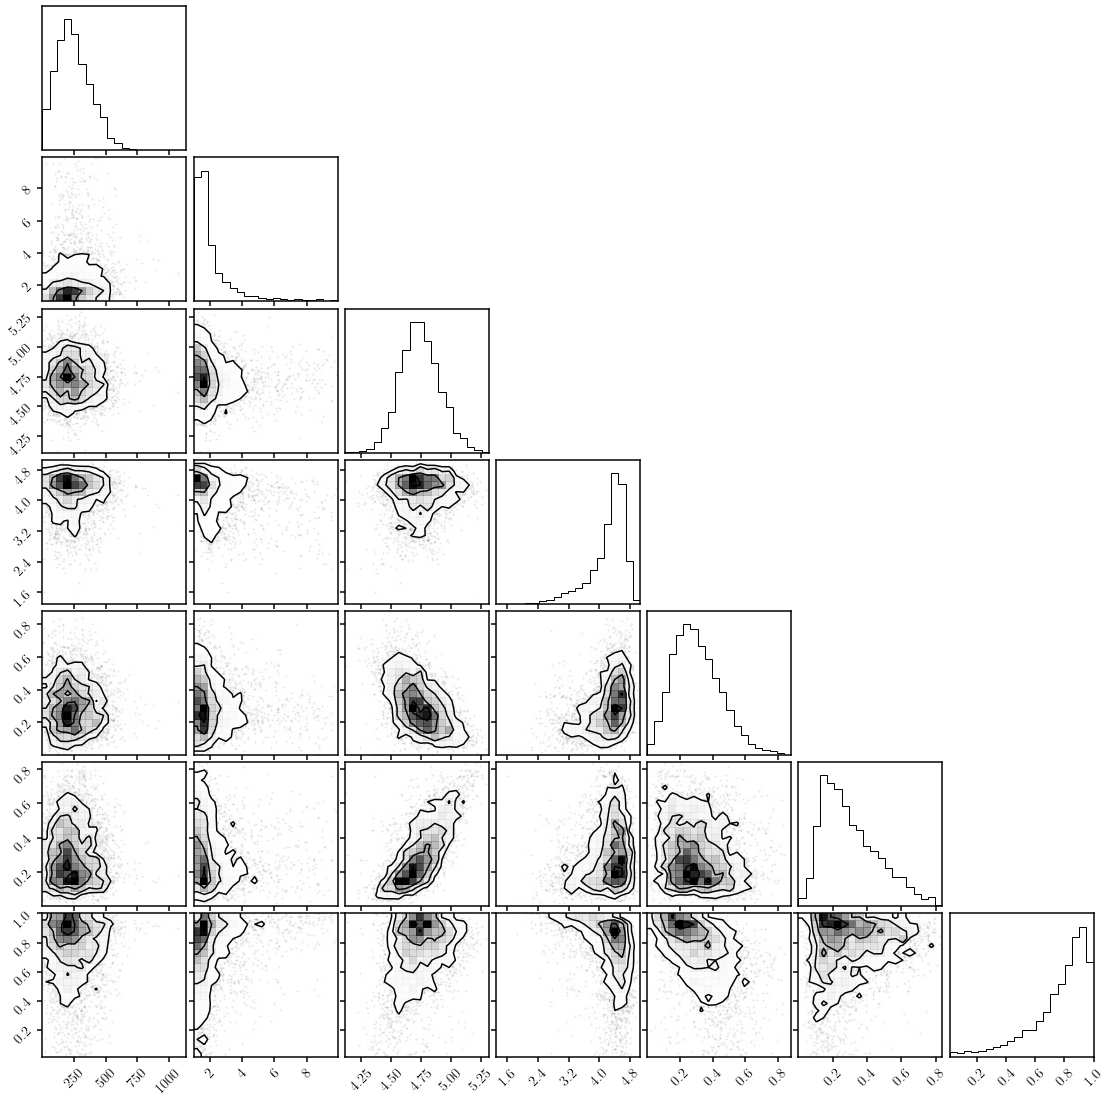

In [15]:
fig = DFM.corner(_data)

# train $Q_\phi(X)$

In [17]:
def train_support(batch_size=50, n_blocks=5, n_hidden=128, lrate=1e-3, patience=10, nepoch=1000, clip_max_norm=5): 
    print('training Qphi for non-participant')
    data = _data.copy()
    
    data[:,0] = U.inv_cdf_transform(data[:,0], [-1e-3, 1500])
    data[:,1] = U.inv_cdf_transform(data[:,1], [-1e-3, 10])
    data[:,2] = U.inv_cdf_transform(data[:,2], [3, 6])        
    data[:,3] = U.inv_cdf_transform(data[:,3], [1, 6])        
    data[:,4] = U.inv_cdf_transform(data[:,4], [-1e-3, 1+1e-3])            
    data[:,5] = U.inv_cdf_transform(data[:,5], [-1e-3, 1+1e-3])            
    data[:,6] = U.inv_cdf_transform(data[:,6], [-1e-3, 1+1e-3])      

    # shuffle up the data 
    np.random.seed(0)
    ind = np.arange(data.shape[0])
    np.random.shuffle(ind)
    
    # set up training/testing data
    Ntrain = int(0.9 * data.shape[0])
    print('Ntrain= %i, Nvalid= %i' % (Ntrain, data.shape[0] - Ntrain))
    data_train = data[ind][:Ntrain]
    data_valid = data[ind][Ntrain:]
    
    ndim = data.shape[1]
    print('n_dim = %i' % ndim)
    
    train_loader = torch.utils.data.DataLoader(torch.tensor(data_train.astype(np.float32)).to(device), 
                                               batch_size=batch_size, shuffle=True)
    valid_loader = torch.utils.data.DataLoader(torch.tensor(data_valid.astype(np.float32)).to(device), 
                                               batch_size=batch_size, shuffle=False)
    
    # initialize flow 
    blocks = []
    for iblock in range(n_blocks): 
        blocks += [transforms.MaskedAffineAutoregressiveTransform(features=ndim, hidden_features=n_hidden),
                transforms.RandomPermutation(features=ndim)]
    transform = transforms.CompositeTransform(blocks)

    base_distribution = distributions.StandardNormal(shape=[ndim])
    flow = flows.Flow(transform=transform, distribution=base_distribution)
    flow.to(device)

    # train flow
    optimizer = optim.Adam(flow.parameters(), lr=lrate)
    #scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, 'min', patience=patience, min_lr=1e-5)
    #optim.lr_scheduler.OneCycleLR(optimizer, lrate, total_steps=num_iter)

    best_epoch, best_valid_loss, valid_losses = 0, np.inf, []
    for epoch in range(nepoch):
        # train 
        flow.train()
        train_loss = 0.
        for batch in train_loader: 
            optimizer.zero_grad()
            loss = -flow.log_prob(batch).mean()
            loss.backward()
            train_loss += loss.item()
            clip_grad_norm_(
                        flow.parameters(), max_norm=clip_max_norm
                    )
            
            optimizer.step()
        train_loss = train_loss/float(len(train_loader))
    
        # validate
        with torch.no_grad():
            valid_loss = 0.
            for batch in valid_loader: 
                loss = -flow.log_prob(batch).mean()
                valid_loss += loss.item()
            valid_loss = valid_loss/len(valid_loader)

            if np.isnan(valid_loss): raise ValueError('nan')

            valid_losses.append(valid_loss)
        #scheduler.step(valid_loss)

        if epoch % 10 == 0: 
            print('Epoch: %i TRAINING Loss: %.2e VALIDATION Loss: %.2e' % 
                          (epoch, train_loss, valid_loss))
            
            #print('Epoch: %i LR %.2e TRAINING Loss: %.2e VALIDATION Loss: %.2e' % 
            #              (epoch, scheduler._last_lr[0], train_loss, valid_loss))
            
        if valid_loss < best_valid_loss: 
            best_valid_loss = valid_loss
            best_epoch = epoch
            best_flow = copy.deepcopy(flow)
        else: 
            if epoch > best_epoch + patience: 
                print('DONE: EPOCH %i, BEST EPOCH %i BEST VALIDATION Loss: %.2e' % 
                          (epoch, best_epoch, best_valid_loss))
                #print('DONE: EPOCH %i, BEST EPOCH %i LR %.2e BEST VALIDATION Loss: %.2e' % 
                #          (epoch, best_epoch, scheduler._last_lr[0], best_valid_loss))
                break 
    return best_flow

In [18]:
flow = train_support(batch_size=50, n_blocks=5, n_hidden=128, lrate=5e-4, patience=20)

training Qphi for non-participant
Ntrain= 3068, Nvalid= 341
n_dim = 7
Epoch: 0 TRAINING Loss: 9.72e+00 VALIDATION Loss: 3.11e+00
Epoch: 10 TRAINING Loss: 1.27e+00 VALIDATION Loss: 1.41e+00
Epoch: 20 TRAINING Loss: 1.12e+00 VALIDATION Loss: 1.23e+00
Epoch: 30 TRAINING Loss: 1.03e+00 VALIDATION Loss: 1.32e+00
Epoch: 40 TRAINING Loss: 9.68e-01 VALIDATION Loss: 1.17e+00
Epoch: 50 TRAINING Loss: 9.09e-01 VALIDATION Loss: 1.22e+00
Epoch: 60 TRAINING Loss: 8.61e-01 VALIDATION Loss: 1.30e+00
DONE: EPOCH 62, BEST EPOCH 41 BEST VALIDATION Loss: 1.14e+00


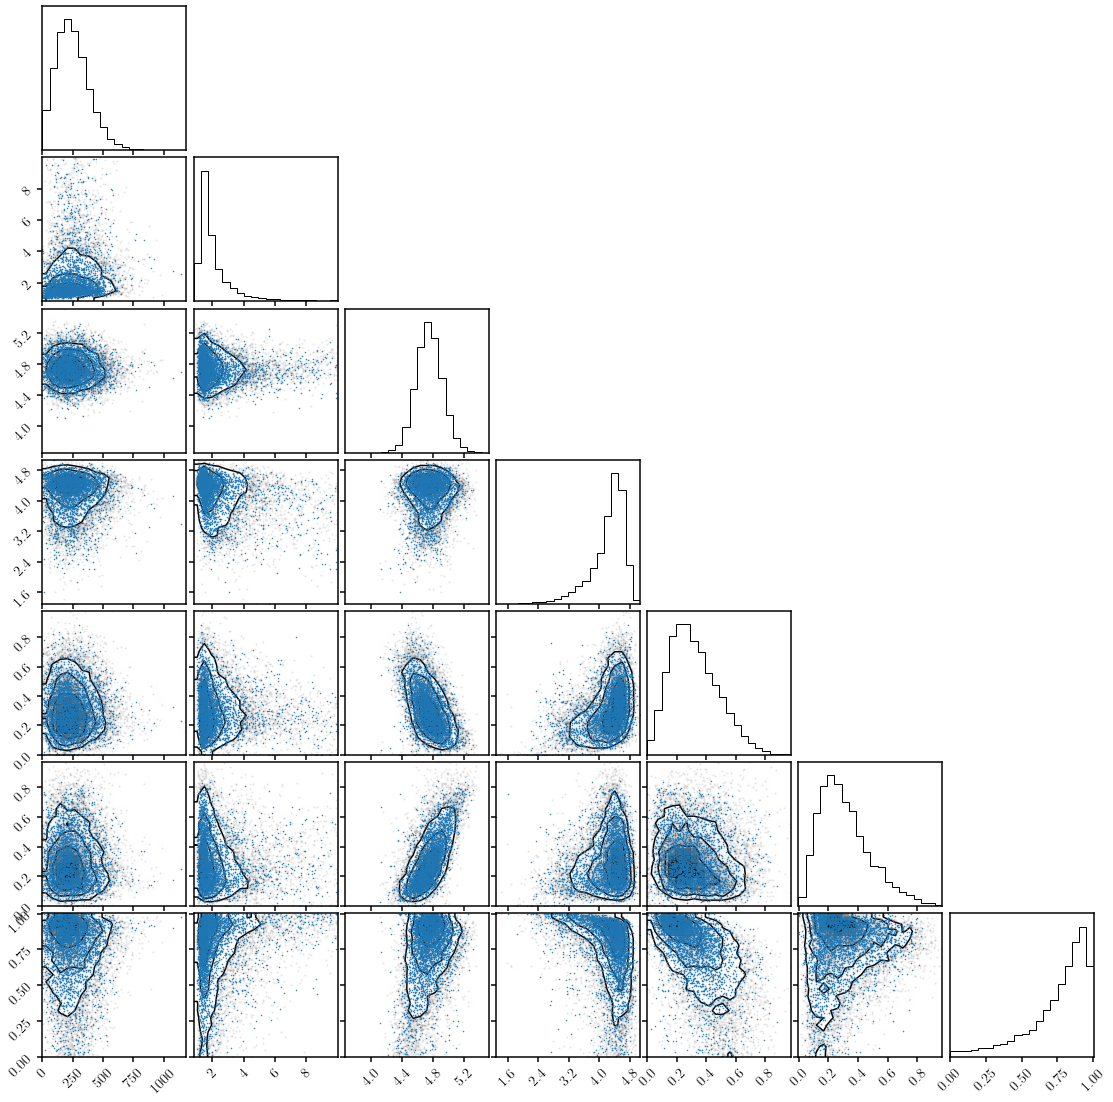

In [20]:
with torch.no_grad(): 
    samp = flow.sample(10000)
    samples = np.array(samp.detach().cpu()).copy()
    samples[:,0] = U.cdf_transform(samples[:,0], [-1e-3, 1500])
    samples[:,1] = U.cdf_transform(samples[:,1], [-1e-3, 10])
    samples[:,2] = U.cdf_transform(samples[:,2], [3, 6])        
    samples[:,3] = U.cdf_transform(samples[:,3], [1, 6])        
    samples[:,4] = U.cdf_transform(samples[:,4], [-1e-3, 1+1e-3])            
    samples[:,5] = U.cdf_transform(samples[:,5], [-1e-3, 1+1e-3])            
    samples[:,6] = U.cdf_transform(samples[:,6], [-1e-3, 1+1e-3])          
fig = DFM.corner(samples)
DFM.overplot_points(fig, _data, markersize=1)        
plt.show()

In [21]:
torch.save(flow, '../dat/qphi/noah2.Qphi_support.nonparticipant.prelim.pt')